<a href="https://colab.research.google.com/github/mdaugherity/MachineLearning2024/blob/main/tutorial/Tutorial_08_First_Classification_Recipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dr. Daugherity, Abilene Christian University PHYS 453**

# Tutorial 8 - First Classification Recipe
In the past several tutorials we have been working through all of the key steps in a proper classification analysis.  Now it is finally time to assemble all of the pieces into a simple and usable recipe.



# Workflow - The Order Is Important!

These are the steps:
1.  **Load Data** - I really mention this as a step because in real-world problems you are likely to spend >80% of your time collecting, reading, exploring, and cleaning data.  
1.  **Test/Train Split** - The first thing you do after getting data is to hide away a portion as your final test set.  Any data that has been *fit* cannot be used for a fair evaluation of the classifier's performance on new data.  Even something as simple as feature scaling can bias results.  
1.  **Pipeline** - Set up all data transforms and your classifier in a pipeline and use it exclusively to access data.  
  1.  **Transforms** - All of the data preprocessing steps such as scaling (which you should nearly always do) and feature engineering
  1.  **Estimator** - The final step in the pipeline is our classifier (or regressor).  The pipeline automatically applies all of the transforms every time we use it.
1.  **Grid Search** - Tune all of the parameters with a cross-validation grid search.  Check for signs of under-fitting and over-fitting by comparing the training and validation scores.
1.  **Final Test** - Only after you are completely done training your model, then you may run it on the saved test set to measure performance on new data.


**NOTES:** In the code below I will keep commentary to a minimum to reduce the amount of stuff you'll have to delete when using this code.  In each section I'll make a special cell for notes instead of sprinkling them everywhere.



In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Common utilities
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Classifiers
from sklearn.neighbors import KNeighborsClassifier

# Load Data



**NOTES**

* User's Guide: https://scikit-learn.org/stable/datasets.html
* Can use return_X_y or as_frame for different formats
* For a spreadsheet you can use [Pandas read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)
* You should clean and plot your data (but we're skipping that step for this lesson)

In [5]:
# Example Bunch Data, see https://scikit-learn.org/stable/modules/generated/sklearn.utils.Bunch.html#sklearn.utils.Bunch
data_bunch = datasets.load_iris(as_frame
data_bunch.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [9]:
X = data_bunch.data
y = data_bunch.target

target_names = data_bunch.target_names
feature_names = data_bunch.feature_names
print('Targets:\t',target_names)
print('Feature:\t',feature_names)
print('Data shape:\t',X.shape)

Targets:	 ['setosa' 'versicolor' 'virginica']
Feature:	 ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Data shape:	 (150, 4)


# Test/Train Split


**NOTES**

Now we split data intro train and test subsets.  **IT IS IMPORTANT TO DO THIS FIRST** before any other operations take place.  I recommend reading through the [common pitfalls](https://scikit-learn.org/stable/common_pitfalls.html) for more insights and discussion.
* only call fit on X_train
* only use X_test to evaulate the final accuracy

Use `stratify=y` to ensure proportional numbers of each target go to each set.

One important clarification: when we tell GridSearchCV to fit X_train, it tunes parameters by further splitting X_train into pieces to make training and [validation](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets) sets.  When we look at GridSearchCV "*test*" scores we are actually looking at portion of X_train, so it is best to call this the validation set.  We never let grid search see X_test until the final evaluation.

Other notes:
* You may want to set ```random_state```
* Default is 75% train, 25% test
* If you have several targets (like more than 2) it is good to use stratify so equal ratios of each target go in to each set

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y) # stratify ensures an equal ratio of each target

# Train

**Notes**

The next steps will happen inside a [pipeline](https://scikit-learn.org/stable/modules/compose.html).  We need to scale the data (and possibly transform it in other exciting ways), and setting up a pipeline ensures that we will treat the test and train sets exactly the same way. See a simple example of pipeline usage [here](https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html#sphx-glr-auto-examples-compose-plot-digits-pipe-py).



Remember that it is vital (for most classifiers) to scale the data first.  The other steps are optional and problem-specific.
* (required) Scaling: use [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler), [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler), or [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler);  see the [User's Guide here](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)
* (optional): other transforms like dimensionality reduction using [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA)

The last step in the pipeline will be the classifier. It is easier to make the pipeline all at once, so we'll do the pipeline code along with the classifiers below.




In [21]:
def plot_2par_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2,show_train=1):
  """Plot GridCV results for two parameter searches"""
  # from https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv with a fixed bug
  val_scores = np.array(cv_results['mean_test_score']).reshape(len(grid_param_1),len(grid_param_2)) # FIXED A BUG HERE
  train_scores = np.array(cv_results['mean_train_score']).reshape(len(grid_param_1),len(grid_param_2))

  _, ax = plt.subplots(1,1,figsize=(10,4))
  cmap = plt.get_cmap("tab10")

  # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
  for idx, val in enumerate(grid_param_2):
    ax.plot(grid_param_1, val_scores[:,idx], '-o',  color=cmap(idx), label=f"Validation: {name_param_2}={str(val)}") # FIXED
    if show_train: ax.plot(grid_param_1, train_scores[:,idx], ':.', color=cmap(idx), label=f"Train: {name_param_2}={str(val)}")

  ax.set_title("Grid Search Scores")
  ax.set_xlabel(name_param_1)
  ax.set_ylabel('CV Average Score')
  ax.legend(loc='upper right')
  ax.grid('on')

Grid Parameters: {'clf__n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8]), 'clf__weights': ['uniform', 'distance']}
Best parameters: {'clf__n_neighbors': 7, 'clf__weights': 'distance'}
Best Train Score:	0.955


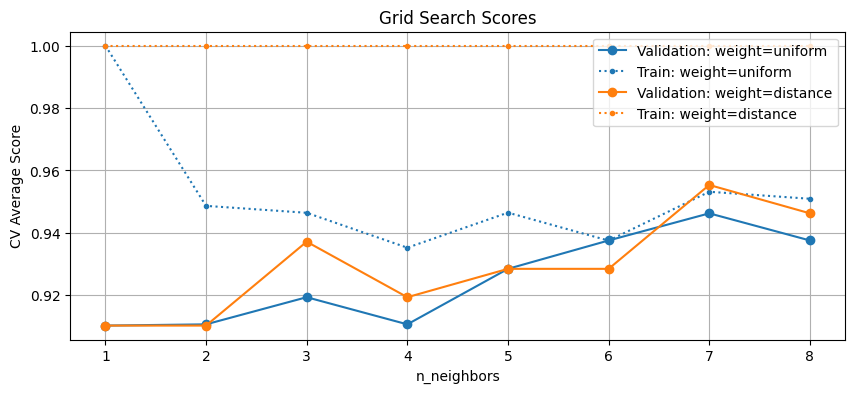

In [43]:
# Define Pipeline
estimators = [('scaler', StandardScaler()), ('clf', KNeighborsClassifier()) ]
pipe = Pipeline(estimators)

# Grid Search Parameters
KLIST = np.arange(1,9)
WLIST = ['uniform','distance']
params = {'clf__n_neighbors':KLIST, 'clf__weights':WLIST}
print('Grid Parameters:',params)

grid_clf = GridSearchCV(pipe, param_grid=params, return_train_score=True)
grid_clf.fit(X_train, y_train)

plot_2par_grid_search(grid_clf.cv_results_, KLIST, WLIST, 'n_neighbors', 'weight')

print('Best parameters:', grid_clf.best_params_)
print(f"Best Train Score:\t{grid_clf.best_score_:0.3f}")

# Evaluate

**NOTES**

* Do not run this code until you are done training your model
* Don't have data leakage.  Do not go back and adjust options to improve test scores

In [47]:
print(f"Grid Test SCORE:\t{grid_clf.score(X_test,y_test):0.3f}")
y_pred = grid_clf.predict(X_test)

Grid Test SCORE:	1.000


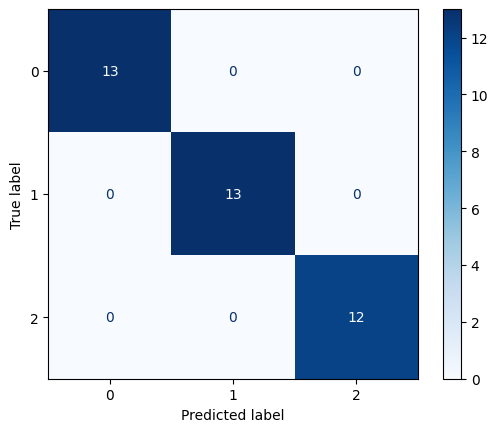

In [49]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.show()

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38

